# Prototpye 3 Intermediate - Using MEED dataset in a transformer

Use normalised keypoint values in a transformer. Encoding for emotion to video during training is not implemented yet, so none of the videos are trained with the emotions and are trained concat indiscriminantly. Will implement separate videos depending on emotional context after.

!The starting input is currently 1 long list of coords. But be careful because model might learn the transition between 1 video to another which is erroneous

Front videos only.

Adapted from Karpathy's nano-gpt , generator only

In [80]:
# set up environment
import glob
import os 
import numpy as np
import torch
import json
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Set root directory
root_dir = "C:\\Users\\avika\\OneDrive\\Documents\\UAL\\interactive_dance_thesis"
os.chdir(root_dir)

# Check if the current working directory was set correctly
print(os.getcwd())

C:\Users\avika\OneDrive\Documents\UAL\interactive_dance_thesis


## Load and preprocess data

In [314]:
import json
import logging
import glob

from typing import List

logger = logging.getLogger()
# Clear previous handlers
for handler in logger.handlers[:]:
    handler.close()
    logger.removeHandler(handler)

logging.basicConfig(filename= f"preprocessing_log.txt", level=logging.INFO, filemode='w')
# logging clear file
logger = logging.getLogger()

def interpolate(coord_prev, coord_next):
    """
    Linearly interpolate between two coordinates.
    
    Parameters:
    - coord_prev (float): Coordinate of the previous frame.
    - coord_next (float): Coordinate of the next frame.

    Returns:
    - (float): Interpolated coordinate.
    """
    return (coord_prev + coord_next) / 2

def preprocess_data(files: List[str]) -> dict:
    """
    Pre-process data by interpolating to avoid (0,0) keypoints.

    Parameters:
    - files (List[str]): List of file paths to process.

    Returns:
    - dict: Pre-processed data.
    """
    x_list=[]
    y_list=[]
    conf_list=[]
    
    for file in tqdm(files):
        with open(file) as f:
            data = json.load(f)
            x = data['x']
            y = data['y']
            conf = data['confidence']
            
            for i in range(len(x)):
                # Check if coordinate is (0,0)
                if x[i] == 0 and y[i] == 0:
                    # logger.info(f"Found (0,0) at index {i} in file {file}")
                    # If first frame, copy from next frame
                    if i == 0:
                        j = i + 1
                        # Find next non-(0,0) frame
                        while x[j] == 0 and y[j] == 0:
                            j += 1
                        x[i] = x[j]
                        y[i] = y[j]
                    # If last frame, copy from previous frame
                    elif i == len(x) - 1:
                        x[i] = x[i-1]
                        y[i] = y[i-1]
                    # For a frame in the middle
                    else:
                        # Find the next non-(0,0) frame
                        j = i + 1
                        while j < len(x) and x[j] == 0 and y[j] == 0:
                            j += 1
                        # If no non-(0,0) frame found, use the previous frame, otherwise interpolate
                        if j == len(x):
                            x[i] = x[i-1]
                            y[i] = y[i-1]
                        else:
                            x[i] = interpolate(x[i-1], x[j])
                            y[i] = interpolate(y[i-1], y[j])
            
            x_list.extend(x)
            y_list.extend(y)
            conf_list.extend(conf)

    return {"x": x_list, "y": y_list, "confidence": conf_list}


files = glob.glob("G:/UAL_Thesis/affective_computing_datasets/multiview-emotional-expressions-dataset/*/front_*/processed_data.json")
processed_data = preprocess_data(files)
x_list = processed_data['x']
y_list = processed_data['y']
conf_list = processed_data['confidence']

print(len(x_list))

100%|██████████| 1326/1326 [00:07<00:00, 179.74it/s]

3214750


In [315]:
# check if there are still 0,0 coordinates

for i in range(len(x_list)):
    if x_list[i] == 0 and y_list[i] == 0:
        print(i)

In [82]:
import cv2



max_x, min_x = max(x_list), min(x_list)

max_y, min_y = max(y_list), min(y_list)

    # create 1D array of 50 numbers (x,y,x,y --> 25 keypoints) for each frame
all_frames = []
n_parts = 25

for i in tqdm(range(0, len(x_list), n_parts)):
    frame_data = [coord for pair in zip(x_list[i:i+n_parts], y_list[i:i+n_parts]) for coord in pair]
    all_frames.append(frame_data)

# data has 0s - need to ignore

def visualise_skeleton(all_frames, max_x, max_y, max_frames=100, save=False, save_path=None, prefix=None):
    
    """Input all frames dim 50xn n being the number of frames 50= 25 keypoints x and y coordinates"""

    
    # visualise to check if the data is correct
    # BODY_25 Keypoints
    keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                        'L-Elb', 'L-Wr', 'MidHip', 'R-Hip', 'R-Knee', 'R-Ank', 
                        'L-Hip', 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 
                        'L-Ear', 'L-BigToe', 'L-SmallToe', 'L-Heel', 'R-BigToe', 
                        'R-SmallToe', 'R-Heel']


    limb_connections = [
        ("Nose", "Neck"),
        ("Neck", "R-Sho"),
        ("R-Sho", "R-Elb"),
        ("R-Elb", "R-Wr"),
        ("Neck", "L-Sho"),
        ("L-Sho", "L-Elb"),
        ("L-Elb", "L-Wr"),
        ("Neck", "MidHip"),
        ("MidHip", "R-Hip"),
        ("R-Hip", "R-Knee"),
        ("R-Knee", "R-Ank"),
        ("MidHip", "L-Hip"),
        ("L-Hip", "L-Knee"),
        ("L-Knee", "L-Ank"),
        ("Nose", "R-Eye"),
        ("R-Eye", "R-Ear"),
        ("Nose", "L-Eye"),
        ("L-Eye", "L-Ear"),
        ("L-Ank", "L-BigToe"),
        ("L-Ank", "L-SmallToe"),
        ("L-Ank", "L-Heel"),
        ("R-Ank", "R-BigToe"),
        ("R-Ank", "R-SmallToe"),
        ("R-Ank", "R-Heel")
    ]

    
    # Initialize a blank canvas (image)
    canvas_size = (int(max_y)+50, int(max_x)+50, 3)  
    canvas = np.zeros(canvas_size, dtype=np.uint8)

    # Define the codec and create VideoWriter object
    if save:
        # Determine the save path
        if save_path is None:
            save_path = "D:\\Interactive Dance Thesis Tests\\TransformerResults"

        # Ensure directory exists
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Determine a unique filename
        existing_files = os.listdir(save_path)
        file_num = 1
        while f"{prefix or ''}{file_num}.mp4" in existing_files:
            file_num += 1
        out_path = os.path.join(save_path, f"{prefix or ''}{file_num}.mp4")

        # Create the video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(out_path, fourcc, 10.0, (canvas_size[1], canvas_size[0]))

    # Iterate over every frame
    for frame_data in all_frames[:max_frames]:
        canvas_copy = canvas.copy()

        # Extract x and y coordinates
        x_coords = frame_data[0::2] 
        y_coords = frame_data[1::2]

        # Plot keypoints on the canvas
        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            x_val = x.item() if torch.is_tensor(x) else x
            y_val = y.item() if torch.is_tensor(y) else y
            cv2.circle(canvas_copy, (int(x_val), int(y_val)), 3, (0, 0, 255), -1)  
            cv2.putText(canvas_copy, keypointsMapping[i], (int(x_val), int(y_val)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        # Draw connections (limbs) on the canvas
        for limb in limb_connections:
            start_point = (int(x_coords[keypointsMapping.index(limb[0])]), int(y_coords[keypointsMapping.index(limb[0])]))
            end_point = (int(x_coords[keypointsMapping.index(limb[1])]), int(y_coords[keypointsMapping.index(limb[1])]))

            if start_point == (0,0) or end_point == (0,0):
                continue
            cv2.line(canvas_copy, start_point, end_point, (0, 255, 0), 2)  

        # Display the canvas with keypoints and connections
        cv2.imshow("Keypoints Visualization", canvas_copy)

        # If saving, write the frame to the video
        if save:
            out.write(canvas_copy)

        # Wait for 100ms and check for "esc" key press to exit
        key = cv2.waitKey(100)
        if key == 27:  
            break

    # Release the video writer, if used
    if save:
        out.release()

    cv2.destroyAllWindows()


100%|██████████| 128590/128590 [00:00<00:00, 134389.91it/s]


In [83]:
# Normalize the data from -1 to 1 for x and y coordinates (maybe try changing normalization to 0 to 1)? -
# using -1 to 1 with tanh for now because motion likely to be concentrated in centre of frame

max_x, min_x = max(x_list), min(x_list)
normalised_x = [2 * (x_pos - min_x) / (max_x - min_x) - 1 for x_pos in x_list]

max_y, min_y = max(y_list), min(y_list)
normalised_y = [2 * (y_pos - min_y) / (max_y - min_y) - 1 for y_pos in y_list]


normalised_x[:5]

[0.1286618142238305,
 0.15734808743478146,
 0.06143265647277163,
 0.023266103374514513,
 -0.005475801440883998]

In [84]:

# create 1D array of 50 numbers (x,y,x,y --> 25 keypoints) for each frame
kp_frame = []
n_parts = 25

for i in tqdm(range(0, len(normalised_x), n_parts)):
    frame_data = [coord for pair in zip(normalised_x[i:i+n_parts], normalised_y[i:i+n_parts]) for coord in pair]
    kp_frame.append(frame_data)

len(kp_frame)

100%|██████████| 128590/128590 [00:00<00:00, 274318.08it/s]


128590

In [85]:
data = torch.tensor(kp_frame, dtype= torch.float32)
print(data.shape, data.dtype)
print(data[:5])

torch.Size([128590, 50]) torch.float32
tensor([[ 1.2866e-01, -3.2150e-01,  1.5735e-01, -1.5077e-01,  6.1433e-02,
         -1.5612e-01,  2.3266e-02,  4.1951e-02, -5.4758e-03,  2.1801e-01,
          2.5793e-01, -1.5055e-01,  2.8178e-01,  5.2984e-02,  3.0078e-01,
          2.4553e-01,  1.5227e-01,  2.1811e-01,  8.0642e-02,  2.1803e-01,
          7.5831e-02,  5.4838e-01,  6.1351e-02,  8.6205e-01,  2.1485e-01,
          2.1817e-01,  2.4333e-01,  5.5376e-01,  2.7228e-01,  8.5635e-01,
          1.0940e-01, -3.3802e-01,  1.5706e-01, -3.4887e-01,  8.5479e-02,
         -3.1032e-01,  2.0018e-01, -3.2691e-01,  3.0075e-01,  9.3343e-01,
          3.2008e-01,  9.1145e-01,  2.6246e-01,  8.7288e-01,  5.6589e-02,
          9.4453e-01,  2.7848e-02,  9.3361e-01,  7.0991e-02,  8.7845e-01],
        [ 1.3328e-01, -3.2134e-01,  1.6201e-01, -1.5077e-01,  6.6220e-02,
         -1.5618e-01,  2.7982e-02,  4.7432e-02, -7.7984e-04,  2.2369e-01,
          2.6270e-01, -1.4535e-01,  2.8187e-01,  5.8513e-02,  3.0550e-01

In [86]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [87]:
block_size = 8
train_data[:block_size+1]

tensor([[ 1.2866e-01, -3.2150e-01,  1.5735e-01, -1.5077e-01,  6.1433e-02,
         -1.5612e-01,  2.3266e-02,  4.1951e-02, -5.4758e-03,  2.1801e-01,
          2.5793e-01, -1.5055e-01,  2.8178e-01,  5.2984e-02,  3.0078e-01,
          2.4553e-01,  1.5227e-01,  2.1811e-01,  8.0642e-02,  2.1803e-01,
          7.5831e-02,  5.4838e-01,  6.1351e-02,  8.6205e-01,  2.1485e-01,
          2.1817e-01,  2.4333e-01,  5.5376e-01,  2.7228e-01,  8.5635e-01,
          1.0940e-01, -3.3802e-01,  1.5706e-01, -3.4887e-01,  8.5479e-02,
         -3.1032e-01,  2.0018e-01, -3.2691e-01,  3.0075e-01,  9.3343e-01,
          3.2008e-01,  9.1145e-01,  2.6246e-01,  8.7288e-01,  5.6589e-02,
          9.4453e-01,  2.7848e-02,  9.3361e-01,  7.0991e-02,  8.7845e-01],
        [ 1.3328e-01, -3.2134e-01,  1.6201e-01, -1.5077e-01,  6.6220e-02,
         -1.5618e-01,  2.7982e-02,  4.7432e-02, -7.7984e-04,  2.2369e-01,
          2.6270e-01, -1.4535e-01,  2.8187e-01,  5.8513e-02,  3.0550e-01,
          2.6204e-01,  1.5239e-01,  2

In [88]:
np.shape(train_data)

torch.Size([115731, 50])

In [89]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel? - every forward and backward pass in transformer
block_size = 16 # what is the maximum context length for predictions?

def get_batch(split):
    data = train_data if split == 'train' else val_data

    # We need to account for the fact that our data is 2-dimensional when creating batches.
    ix = torch.randint(len(data) - block_size, (batch_size,))
    
    # Adjusted these lines to consider the 50-dimensional poses
    x = torch.stack([data[i:i+block_size, :] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1, :] for i in ix])
    
    # Compute the mask to mask out -inf values
    mask = (x != float('-inf')).all(dim=-1).float()  # this assumes -inf is present in any part of the data point

    x, y, mask = x.to(device), y.to(device), mask.to(device)
    
    x, y = x.to(device), y.to(device)
    return x, y ,mask


xb, yb,mask = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

# each 4x8 array contains 32 examples of context-target pairs which is completely independent of each other to the transformer
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

# x will be the input, and transformer will look at all examples and look at the target y 

inputs:
torch.Size([4, 16, 50])
tensor([[[ 0.1523, -0.2773,  0.1526,  ...,  0.7906,  0.0951,  0.7410],
         [ 0.1478, -0.2826,  0.1525,  ...,  0.7905,  0.0951,  0.7410],
         [ 0.1478, -0.2774,  0.1525,  ...,  0.7903,  0.0950,  0.7409],
         ...,
         [ 0.1429, -0.2829,  0.1526,  ...,  0.7958,  0.0950,  0.7519],
         [ 0.1428, -0.2829,  0.1570,  ...,  0.7905,  0.0952,  0.7465],
         [ 0.1429, -0.2830,  0.1526,  ...,  0.7904,  0.0950,  0.7465]],

        [[ 0.2289, -0.2663,  0.2243,  ...,  0.9005,  0.1909,  0.8454],
         [ 0.2289, -0.2663,  0.2242,  ...,  0.9059,  0.1908,  0.8456],
         [ 0.2289, -0.2663,  0.2196,  ...,  0.9006,  0.1908,  0.8400],
         ...,
         [ 0.2149, -0.2609,  0.2052,  ...,  0.9059,  0.1954,  0.8565],
         [ 0.2148, -0.2662,  0.2052,  ...,  0.9005,  0.1907,  0.8401],
         [ 0.2146, -0.2610,  0.2052,  ...,  0.9059,  0.1908,  0.8510]],

        [[ 0.0519, -0.3543,  0.1046,  ...,  0.7740,  0.1046,  0.7299],
         [ 0.

In [90]:
# class LayerNorm1d: # (used to be BatchNorm1d) - Layer normalisation in pytorch - overcome optimisation issue for deep nn
#   # running buffers not maintained
#   # apply before SA blocks - different from original transformer paper   - prenorm transformation
#   # Currenly not used and using nn.LayerNorm(n_emb , device=device)

#   def __init__(self, dim, eps=1e-5, momentum=0.1):
#     self.eps = eps
#     self.gamma = torch.ones(dim,device=device)
#     self.beta = torch.zeros(dim,device=device)

#   def __call__(self, x):
#     # calculate the forward pass
#     xmean = x.mean(1, keepdim=True) # batch mean  - normalise rows not columns (dim = 1)
#     xvar = x.var(1, keepdim=True) # batch variance - normalise rows not columns (dim = 1)
#     xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
#     self.out = self.gamma * xhat + self.beta
#     return self.out

#   def parameters(self):
#     return [self.gamma, self.beta]
        

In [91]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

torch.manual_seed(1337)

# let's start with a very simple model

def positional_encoding(seq_len, d_model):
    """
    Returns the positional encoding for a given sequence length and model size.

    Parameters:
    - seq_len (int): Length of the sequence.
    - d_model (int): Size of the model embedding.

    Returns:
    - A tensor of shape (seq_len, d_model) containing the positional encoding.
    """
    
    position = torch.arange(seq_len).unsqueeze(1).float() # [seq_len, 1]
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                         (-math.log(10000.0) / d_model))  # [d_model/2]
    pos_enc = torch.zeros((seq_len, d_model))

    pos_enc[:, 0::2] = torch.sin(position * div_term) # apply sin to even indices in the array; 2i
    pos_enc[:, 1::2] = torch.cos(position * div_term) # apply cos to odd indices in the array; 2i+1

    return pos_enc


class Head(nn.Module):
    """one head of self attention"""
    
    def __init__(self,head_size,n_emb,dropout=0.1):
        super().__init__()
        self.key = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.query = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.value = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.n_emb = n_emb
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        B,T,C = x.shape # batch size, time, context
        # key, query, value
        k = self.key(x) # B,T,C
        q = self.query(x) # B,T,C
        v= self.value(x) # B,T,C
        
        # compute attention scores ("affinities")
         # Scaled dot-product attention - same as below
        # attention = torch.einsum("nqhd,nkhd->nhqk", [queries, keys]) / math.sqrt(self.embed_size)

        wei = q @ k.transpose(-1,-2) # B,T,T
        wei /= math.sqrt(self.n_emb) # scale by sqrt of embedding dimension
        self.tril = self.tril.to(device)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # mask out upper triangular part so don't attend to future
        wei = F.softmax(wei, dim=-1) # B,T,T
        wei = self.dropout(wei)
        # apply attention to values - weighted aggregation
        out = wei @ v # (B,T,T) @ (B,T,C) --> B,T,C
        
        return out
        
        
class MultiHeadAttention(nn.Module):
    
    def __init__(self,num_heads,head_size,n_emb,dropout=0.1):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size,n_emb) for _ in range(num_heads)])
        self.proj = nn.Linear(n_emb, n_emb, bias=False, device=device) # (B,T,C) - projection back into residual pathway
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x is (B,T,C)
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B,T,C*num_heads)
        out = self.dropout(self.proj(out)) # (B,T,C) - projection back into residual pathway
        
        return out
    
class FeedForward(nn.Module):
    """A simple lineear layer followed by a ReLU - allows all tokens to think on data individually"""
    
    def __init__(self,n_emb,dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_emb, 4 * n_emb , device=device), # 4 * because recommended in paper residual pathway - growing residual pathway
            nn.ReLU(),
            nn.Linear( 4* n_emb, n_emb , device=device), # required otherwise output will collapse  - projection back into residual pathway
            nn.Dropout(dropout)
          
        )
    
    def forward(self, x):
        return self.net(x)
    

class Block(nn.Module):
    """Transformer Block: communication followed by computation - basically self attention heads and feedforward"""

    def __init__(self, n_emb, n_heads):
        
        super().__init__()
        head_size = n_emb//n_heads
        self.sa = MultiHeadAttention(num_heads=n_heads, head_size=head_size, n_emb=n_emb)
        self.ffwd = FeedForward(n_emb=n_emb)
        self.ln1 =  nn.InstanceNorm1d(n_emb , device=device)
        self.ln2 =  nn.InstanceNorm1d(n_emb, device=device)
        
    def forward(self, x):
        # x + due to residual connection
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class MotionModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim=256, n_layers=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False, device=device) 
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=False,device=device)
        # PROBLEM
        self.positional_encoding = positional_encoding(seq_len=block_size, d_model=hidden_dim).to(device)
        layers = [Block(n_emb=hidden_dim, n_heads=4) for _ in range(n_layers)]
        layers.append(nn.InstanceNorm1d(hidden_dim, device=device))
        self.blocks = nn.Sequential(*layers)

        self.lm_head = nn.Linear(hidden_dim, hidden_dim, bias=False, device=device)
       
    
        
    def forward(self, inputs, targets=None ,mask=None):
        B,T,C = inputs.shape # batch size, time, context
        
        # fc1 transforms input into hidden dimension
        x = self.fc1(inputs) # B,T,hidden dimension
        # Add positional encoding
       
        x += positional_encoding(seq_len=T, d_model=self.hidden_dim).to(device) # positional_encoding = T,hidden dimension , added = B,T,hidden dimension
        
        x = self.blocks(x) # B,T,hidden dimension
        x = self.lm_head(x) # B,T,hidden dimension
        
        # fc2 transforms hidden dimension into output dimension
        logits = self.fc2(x)
        
        
        if targets is None:
            loss = None
        
        else:
            B,T,C = inputs.shape # batch size, time, context
            loss = F.mse_loss(logits, targets) # mse picked cause continous data
            # adding mask to ignore 0,0 occlusions (-inf)
            # if mask is None:
            #     mask = (inputs != float('-inf')).all(dim=-1).float() 
              
            # loss = F.mse_loss(logits * mask.unsqueeze(-1), targets * mask.unsqueeze(-1), reduction='sum') / mask.sum()

        
        return logits,loss
    
    def generate(self,inputs,max_new_tokens):
        # inputs is (B,T) array of indices in current context
        # get current prediction
    
        generated_sequence = inputs
        
        for _ in range(max_new_tokens):
            cond_sequence = generated_sequence[:, -block_size:] # get the last block_size tokens from the generated sequence so positional doesn't run out
            # don't actually need to do this cause positional is sinusoidal but just in case since model trained with blocksize
            logits, _ = self(cond_sequence)
            next_values = logits[:, -1, :]  # Get the values from the last timestep
            
            # Append the predicted values to the sequence
            generated_sequence = torch.cat([generated_sequence, next_values.unsqueeze(1)], dim=1)
        
        return generated_sequence

    
m = MotionModel(input_dim=50, output_dim=50)
out,loss = m(xb, yb)
print(out.shape)
print(out)
# loss interpreted on scale of data
print(f"loss: {loss}")


            
    

torch.Size([4, 16, 50])
tensor([[[-0.1342,  0.0328,  0.6273,  ...,  0.1692, -0.0610,  0.2062],
         [-0.2059, -0.2954,  0.4954,  ...,  0.1766, -0.1028,  0.3939],
         [-0.2714,  0.1548,  0.7609,  ...,  0.2391, -0.0707,  0.3940],
         ...,
         [-0.0998, -0.2580,  0.7071,  ...,  0.4854, -0.4234,  0.6325],
         [-0.3229, -0.2496,  0.7006,  ...,  0.8275, -0.4827,  0.4840],
         [-0.6083, -0.0497,  0.5424,  ...,  0.6289, -0.2936,  0.3122]],

        [[-0.0305, -0.2975,  0.6182,  ...,  0.2819, -0.0776,  0.4202],
         [-0.0454, -0.4812,  0.5460,  ...,  0.3813, -0.1194,  0.4089],
         [-0.0352, -0.2288,  0.5914,  ...,  0.1216, -0.0089,  0.4312],
         ...,
         [ 0.1503, -0.2933,  0.5646,  ...,  0.2737, -0.2807,  0.4642],
         [-0.1018, -0.3725,  0.6838,  ...,  0.7026, -0.2548,  0.4336],
         [-0.3100, -0.1106,  0.6007,  ...,  0.5567, -0.4415,  0.1004]],

        [[-0.3712, -0.1800,  0.6071,  ...,  0.2272, -0.3089,  0.3947],
         [-0.2267, -0

In [92]:
optimizer = torch.optim.Adam(m.parameters(), lr=0.0001)

  0%|          | 4/500000 [02:14<3539:40:50, 25.49s/it]  

train loss: 0.000897 val loss: 0.000852


  1%|          | 5004/500000 [07:42<1375:41:47, 10.01s/it]

train loss: 0.000740 val loss: 0.000733


  2%|▏         | 10004/500000 [13:09<1354:40:14,  9.95s/it]

train loss: 0.000653 val loss: 0.000673


  3%|▎         | 15004/500000 [18:35<1325:12:37,  9.84s/it]

train loss: 0.000674 val loss: 0.000729


  4%|▍         | 20004/500000 [23:54<1306:32:23,  9.80s/it]

train loss: 0.000758 val loss: 0.000725


  5%|▌         | 25004/500000 [29:12<1287:17:34,  9.76s/it]

train loss: 0.000611 val loss: 0.000690


  6%|▌         | 30004/500000 [34:31<1272:50:28,  9.75s/it]

train loss: 0.000595 val loss: 0.000674


  7%|▋         | 35004/500000 [39:50<1261:37:29,  9.77s/it]

train loss: 0.000617 val loss: 0.000699


  8%|▊         | 40004/500000 [45:09<1248:33:25,  9.77s/it]

train loss: 0.000591 val loss: 0.000749


  9%|▉         | 45004/500000 [50:28<1232:35:14,  9.75s/it]

train loss: 0.000565 val loss: 0.000681


 10%|█         | 50004/500000 [55:46<1217:13:21,  9.74s/it]

train loss: 0.000562 val loss: 0.000665


 11%|█         | 55004/500000 [1:01:05<1206:46:41,  9.76s/it]

train loss: 0.000551 val loss: 0.000694


 12%|█▏        | 60004/500000 [1:06:22<1192:16:39,  9.76s/it]

train loss: 0.000543 val loss: 0.000638


 13%|█▎        | 65004/500000 [1:11:41<1177:17:52,  9.74s/it]

train loss: 0.000567 val loss: 0.000762


 14%|█▍        | 70004/500000 [1:16:58<1160:05:05,  9.71s/it]

train loss: 0.000513 val loss: 0.000657


 15%|█▌        | 75004/500000 [1:22:16<1153:23:57,  9.77s/it]

train loss: 0.000579 val loss: 0.000766


 16%|█▌        | 80004/500000 [1:27:35<1140:16:02,  9.77s/it]

train loss: 0.000529 val loss: 0.000745


 17%|█▋        | 85004/500000 [1:32:54<1124:58:25,  9.76s/it]

train loss: 0.000476 val loss: 0.000670


 18%|█▊        | 90004/500000 [1:38:12<1106:17:53,  9.71s/it]

train loss: 0.000500 val loss: 0.000794


 19%|█▉        | 95004/500000 [1:43:30<1096:05:52,  9.74s/it]

train loss: 0.000482 val loss: 0.000672


 20%|██        | 100004/500000 [1:48:49<1086:13:04,  9.78s/it]

train loss: 0.000532 val loss: 0.000754


 21%|██        | 105004/500000 [1:54:08<1071:53:12,  9.77s/it]

train loss: 0.000469 val loss: 0.000706


 22%|██▏       | 110004/500000 [1:59:26<1053:42:30,  9.73s/it]

train loss: 0.000469 val loss: 0.000670


 23%|██▎       | 115004/500000 [2:04:44<1041:59:15,  9.74s/it]

train loss: 0.000471 val loss: 0.000721


 24%|██▍       | 120004/500000 [2:10:03<1031:16:22,  9.77s/it]

train loss: 0.000426 val loss: 0.000686


 25%|██▌       | 125004/500000 [2:15:22<1016:52:23,  9.76s/it]

train loss: 0.000440 val loss: 0.000666


 26%|██▌       | 130004/500000 [2:20:44<1015:16:06,  9.88s/it]

train loss: 0.000424 val loss: 0.000734


 27%|██▋       | 135004/500000 [2:26:12<1005:37:27,  9.92s/it]

train loss: 0.000450 val loss: 0.000700


 28%|██▊       | 140004/500000 [2:31:29<973:45:48,  9.74s/it] 

train loss: 0.000423 val loss: 0.000726


 29%|██▉       | 145004/500000 [2:36:47<963:11:05,  9.77s/it] 

train loss: 0.000404 val loss: 0.000692


 30%|███       | 150004/500000 [2:42:06<950:00:52,  9.77s/it] 

train loss: 0.000436 val loss: 0.000708


 31%|███       | 155004/500000 [2:47:24<932:25:39,  9.73s/it] 

train loss: 0.000435 val loss: 0.000711


 32%|███▏      | 160004/500000 [2:52:43<922:22:09,  9.77s/it] 

train loss: 0.000420 val loss: 0.000658


 33%|███▎      | 165004/500000 [2:58:02<910:16:38,  9.78s/it] 

train loss: 0.000379 val loss: 0.000690


 34%|███▍      | 170004/500000 [3:03:21<895:16:36,  9.77s/it] 

train loss: 0.000371 val loss: 0.000730


 35%|███▌      | 175004/500000 [3:08:40<876:04:20,  9.70s/it] 

train loss: 0.000388 val loss: 0.000740


 36%|███▌      | 180004/500000 [3:13:59<866:42:54,  9.75s/it] 

train loss: 0.000389 val loss: 0.000699


 37%|███▋      | 185004/500000 [3:19:19<858:49:10,  9.82s/it] 

train loss: 0.000386 val loss: 0.000778


 38%|███▊      | 190004/500000 [3:24:42<847:33:54,  9.84s/it] 

train loss: 0.000402 val loss: 0.000895


 39%|███▉      | 195004/500000 [3:30:04<830:46:53,  9.81s/it] 

train loss: 0.000365 val loss: 0.000809


 40%|████      | 200004/500000 [3:35:29<839:15:17, 10.07s/it] 

train loss: 0.000366 val loss: 0.000781


 41%|████      | 205004/500000 [3:41:00<773:50:45,  9.44s/it] 

train loss: 0.000347 val loss: 0.000692


 42%|████▏     | 210004/500000 [3:46:18<785:05:15,  9.75s/it] 

train loss: 0.000403 val loss: 0.000730


 43%|████▎     | 215004/500000 [3:51:36<773:12:51,  9.77s/it] 

train loss: 0.000359 val loss: 0.000805


 44%|████▍     | 220004/500000 [3:56:54<756:08:06,  9.72s/it] 

train loss: 0.000339 val loss: 0.000688


 45%|████▌     | 225004/500000 [4:02:12<747:19:07,  9.78s/it] 

train loss: 0.000428 val loss: 0.000755


 46%|████▌     | 230004/500000 [4:07:31<732:02:13,  9.76s/it] 

train loss: 0.000345 val loss: 0.000740


 47%|████▋     | 235004/500000 [4:12:49<717:47:56,  9.75s/it] 

train loss: 0.000351 val loss: 0.000698


 48%|████▊     | 240004/500000 [4:18:07<703:34:09,  9.74s/it] 

train loss: 0.000338 val loss: 0.000743


 49%|████▉     | 245004/500000 [4:23:24<689:14:35,  9.73s/it] 

train loss: 0.000374 val loss: 0.000798


 50%|█████     | 250004/500000 [4:28:42<677:56:48,  9.76s/it]

train loss: 0.000363 val loss: 0.000719


 51%|█████     | 255004/500000 [4:34:00<660:36:22,  9.71s/it]

train loss: 0.000328 val loss: 0.000824


 52%|█████▏    | 260004/500000 [4:39:16<645:42:25,  9.69s/it]

train loss: 0.000306 val loss: 0.000746


 53%|█████▎    | 265004/500000 [4:44:35<638:43:46,  9.78s/it]

train loss: 0.000320 val loss: 0.000724


 54%|█████▍    | 270004/500000 [4:49:53<624:48:10,  9.78s/it]

train loss: 0.000311 val loss: 0.000778


 55%|█████▌    | 275004/500000 [4:55:14<611:12:02,  9.78s/it]

train loss: 0.000334 val loss: 0.000843


 56%|█████▌    | 280004/500000 [5:00:34<594:43:38,  9.73s/it]

train loss: 0.000350 val loss: 0.000723


 57%|█████▋    | 285004/500000 [5:05:55<583:22:40,  9.77s/it]

train loss: 0.000311 val loss: 0.000701


 58%|█████▊    | 290004/500000 [5:11:17<573:23:05,  9.83s/it]

train loss: 0.000318 val loss: 0.000726


 59%|█████▉    | 295004/500000 [5:16:38<556:41:25,  9.78s/it]

train loss: 0.000318 val loss: 0.000725


 60%|██████    | 300004/500000 [5:21:58<540:40:25,  9.73s/it]

train loss: 0.000417 val loss: 0.000786


 61%|██████    | 305004/500000 [5:27:22<542:09:33, 10.01s/it]

train loss: 0.000297 val loss: 0.000767


 62%|██████▏   | 310004/500000 [5:32:50<516:21:05,  9.78s/it]

train loss: 0.000324 val loss: 0.000745


 63%|██████▎   | 315004/500000 [5:38:16<511:28:09,  9.95s/it]

train loss: 0.000300 val loss: 0.000725


 64%|██████▍   | 320004/500000 [5:43:46<496:17:43,  9.93s/it]

train loss: 0.000289 val loss: 0.000752


 65%|██████▌   | 325004/500000 [5:49:07<473:22:47,  9.74s/it]

train loss: 0.000304 val loss: 0.000717


 66%|██████▌   | 330004/500000 [5:54:30<460:05:51,  9.74s/it]

train loss: 0.000276 val loss: 0.000733


 67%|██████▋   | 335004/500000 [5:59:53<448:54:48,  9.79s/it]

train loss: 0.000336 val loss: 0.000784


 68%|██████▊   | 340004/500000 [6:05:16<434:43:44,  9.78s/it]

train loss: 0.000292 val loss: 0.000714


 69%|██████▉   | 345004/500000 [6:10:38<420:52:08,  9.78s/it]

train loss: 0.000320 val loss: 0.000722


 70%|███████   | 350004/500000 [6:16:00<406:03:05,  9.75s/it]

train loss: 0.000320 val loss: 0.000752


 71%|███████   | 355003/500000 [6:21:26<453:16:40, 11.25s/it]

train loss: 0.000324 val loss: 0.000748


 72%|███████▏  | 360004/500000 [6:27:11<373:10:06,  9.60s/it]

train loss: 0.000275 val loss: 0.000770


 73%|███████▎  | 365004/500000 [6:32:52<385:58:05, 10.29s/it]

train loss: 0.000287 val loss: 0.000829


 74%|███████▍  | 370004/500000 [6:38:33<365:33:06, 10.12s/it]

train loss: 0.000278 val loss: 0.000788


 75%|███████▌  | 375004/500000 [6:44:06<349:32:35, 10.07s/it]

train loss: 0.000302 val loss: 0.000816


 76%|███████▌  | 380004/500000 [6:49:44<319:52:00,  9.60s/it]

train loss: 0.000347 val loss: 0.000811


 77%|███████▋  | 385004/500000 [6:55:25<353:41:05, 11.07s/it]

train loss: 0.000265 val loss: 0.000745


 78%|███████▊  | 390004/500000 [7:00:57<278:02:20,  9.10s/it]

train loss: 0.000272 val loss: 0.000766


 79%|███████▉  | 395004/500000 [7:06:12<282:00:40,  9.67s/it]

train loss: 0.000273 val loss: 0.000691


 80%|████████  | 400004/500000 [7:11:25<268:46:46,  9.68s/it]

train loss: 0.000267 val loss: 0.000838


 81%|████████  | 405004/500000 [7:16:37<254:41:15,  9.65s/it]

train loss: 0.000268 val loss: 0.000743


 82%|████████▏ | 410004/500000 [7:21:51<243:21:24,  9.73s/it]

train loss: 0.000260 val loss: 0.000772


 83%|████████▎ | 415004/500000 [7:27:02<228:03:20,  9.66s/it]

train loss: 0.000264 val loss: 0.000731


 84%|████████▍ | 420004/500000 [7:32:15<214:42:05,  9.66s/it]

train loss: 0.000250 val loss: 0.000757


 85%|████████▌ | 425004/500000 [7:37:28<201:32:04,  9.67s/it]

train loss: 0.000275 val loss: 0.000780


 86%|████████▌ | 430004/500000 [7:42:41<188:42:46,  9.71s/it]

train loss: 0.000297 val loss: 0.000751


 87%|████████▋ | 435004/500000 [7:47:53<174:23:04,  9.66s/it]

train loss: 0.000369 val loss: 0.000759


 88%|████████▊ | 440004/500000 [7:53:06<161:21:45,  9.68s/it]

train loss: 0.000238 val loss: 0.000742


 89%|████████▉ | 445004/500000 [7:58:46<147:10:21,  9.63s/it]

train loss: 0.000240 val loss: 0.000772


 90%|█████████ | 450004/500000 [8:04:23<140:31:59, 10.12s/it]

train loss: 0.000244 val loss: 0.000741


 91%|█████████ | 455004/500000 [8:10:07<133:02:16, 10.64s/it]

train loss: 0.000251 val loss: 0.000756


 92%|█████████▏| 460004/500000 [8:15:54<124:46:18, 11.23s/it]

train loss: 0.000283 val loss: 0.000760


 93%|█████████▎| 465004/500000 [8:21:36<98:30:05, 10.13s/it] 

train loss: 0.000238 val loss: 0.000736


 94%|█████████▍| 470004/500000 [8:26:58<89:21:56, 10.73s/it] 

train loss: 0.000275 val loss: 0.000733


 95%|█████████▌| 475004/500000 [8:32:16<68:16:25,  9.83s/it] 

train loss: 0.000262 val loss: 0.000796


 96%|█████████▌| 480004/500000 [8:37:34<54:45:54,  9.86s/it]

train loss: 0.000260 val loss: 0.000753


 97%|█████████▋| 485004/500000 [8:43:07<43:00:14, 10.32s/it]

train loss: 0.000239 val loss: 0.000736


 98%|█████████▊| 490004/500000 [8:48:48<30:46:18, 11.08s/it]

train loss: 0.000253 val loss: 0.000798


 99%|█████████▉| 495004/500000 [8:54:31<13:27:33,  9.70s/it]

train loss: 0.000233 val loss: 0.000760


100%|██████████| 500000/500000 [8:57:51<00:00, 15.49it/s]   


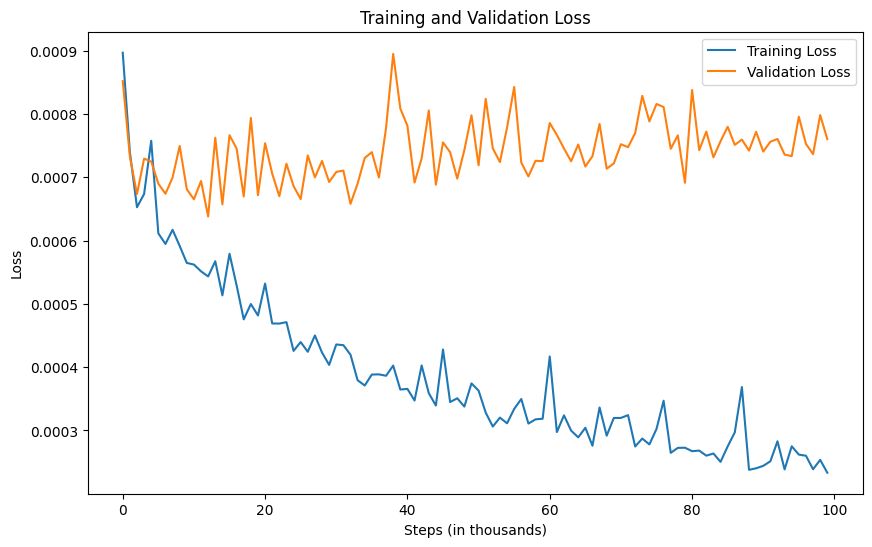

In [101]:
# training loop

import matplotlib.pyplot as plt

@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval()
    eval_iters = 5000
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb, mask = get_batch(split)
            logits, loss = m(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out


batch_size = 8
train_losses = []
val_losses = []
for steps in tqdm(range(500000)):
    # get sample batch of data
    xb,yb,mask = get_batch('train')
    # evaluate loss
    logits, loss = m(xb,yb, mask)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    if steps % 5000 == 0:
        losses = estimate_loss()
        print(f"train loss: {losses['train']:.6f} val loss: {losses['val']:.6f}")
        
         # Store the losses for plotting
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Steps (in thousands)')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# After the training loop, plot the losses
plot_losses(train_losses, val_losses)

In [297]:
# generate new sequence
xb,yb = get_batch('test')

generated = m.generate(xb, 1000)
print(generated.shape)

torch.Size([4, 1016, 50])


In [298]:
def unnormalise_list(data_list, max_x, min_x, max_y, min_y):
    unnormalized_data = []
    for i in range(0, len(data_list), 2):  # Step by 2 to get x, y pairs
        x = data_list[i]
        y = data_list[i+1]
        
        # Unnormalize x and y
        unnormalized_x = (x+1)/2 * (max_x-min_x) + min_x
        unnormalized_y = (y+1)/2 * (max_y-min_y) + min_y
        
        # Append to result list
        unnormalized_data.extend([unnormalized_x, unnormalized_y])
    
    return unnormalized_data




unnorm_out = unnormalise_list(generated, max_x, min_x, max_y, min_y)

# visualise and save
for batch in unnorm_out:
    visualise_skeleton(batch, max_x, max_y, max_frames=100,save = True,save_path=None,prefix='adam_500000steps_optimised_6layer_dropout_lerp')

In [96]:
out.shape

torch.Size([4, 16, 50])

In [97]:
# # continuous GPT


# import torch
# import torch.nn as nn
# from torch.nn import functional as F
# import math

# torch.manual_seed(1337)


# # this is set to eval mode because we don't want to train the model, we just want to estimate the loss, for this model the modes won't be different
# # but for other models, the modes will be different depending on what layers are present
# # torch.no_grad() - we don't want to calculate gradients because we don't want to train the model, we will not call backward, better memory management
# @torch.no_grad()
# def estimate_loss():
#     out = {}
#     model.eval()
#     eval_iters = 200
#     for split in ['train', 'val']:
#         losses = torch.zeros(eval_iters)
#         for k in range(eval_iters):
#             xb, yb = get_batch(split)
#             logits, loss = model(xb, yb)
#             losses[k] = loss.item()
#         out[split] = losses.mean()
#     model.train()
#     return out

# def positional_encoding(seq_len, d_model):
#     """
#     Returns the positional encoding for a given sequence length and model size.

#     Parameters:
#     - seq_len (int): Length of the sequence.
#     - d_model (int): Size of the model embedding.

#     Returns:
#     - A tensor of shape (seq_len, d_model) containing the positional encoding.
#     """
    
#     position = torch.arange(seq_len).unsqueeze(1).float() # [seq_len, 1]
#     div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
#                          (-math.log(10000.0) / d_model))  # [d_model/2]
#     pos_enc = torch.zeros((seq_len, d_model))

#     pos_enc[:, 0::2] = torch.sin(position * div_term) # apply sin to even indices in the array; 2i
#     pos_enc[:, 1::2] = torch.cos(position * div_term) # apply cos to odd indices in the array; 2i+1

#     return pos_enc



# class MotionModel(nn.Module):

#     def __init__(self, input_dim, hidden_dim, num_heads, num_layers):
#         super().__init__()

#         # Initial transformation layer
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
        
#         # Transformer layers
#         encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         # Positional encoding
#         self.positional_encoding = positional_encoding(seq_len=block_size, d_model=hidden_dim).to(device)

#         # Output layer
#         self.fc2 = nn.Linear(hidden_dim, input_dim)

#     def forward(self, pose_sequence,targets=None):
#         # Feature transformation
#         x = self.fc1(pose_sequence)

#         # Add positional encoding
#         seq_len = x.shape[1]
#         x += self.positional_encoding[:seq_len, :]


#         # Transformer layers
#         x = self.transformer(x)

#         # Predicting the next pose
#         logits = self.fc2(x)
        
        
#         if targets is None:
#             loss = None
#         else:
#             B, T, C = logits.shape
#             # pytorch wants (B*T,C) so we have to transpose because it wants C in the 2nd dimension
#             logits = logits.view(B*T, C)
#             # look at prediction
#             targets = targets.view(B*T, -1)

#             # evaluate loss
#             # negative log likelihood loss a.k. cross entropy loss
#             # we have the identity of the next character so how well are we predicting the next character based on the logits
#             # ideally the correct logits should be 1 and the rest should be 0, but in reality this is not the case
            
#             loss = F.cross_entropy(logits, targets)

#         return logits,loss

#     def training_step(self, pose_sequence, next_pose):
#         predicted_pose = self(pose_sequence)
#         loss = nn.MSELoss()(predicted_pose, next_pose)
#         return loss
    
#     def generate(self, initial_pose_sequence, max_new_poses):
#         """
#         Generate a sequence of poses.

#         Parameters:
#         - initial_pose_sequence: Starting sequence of poses.
#         - max_new_poses: Maximum number of new poses to generate.

#         Returns:
#         - Generated sequence of poses.
#         """

#         generated_sequence = initial_pose_sequence

#         for _ in range(max_new_poses):
#             # Get the predicted next pose
#             logits, _ = self(generated_sequence)
#             next_pose = logits


#             # Append the predicted pose to the sequence
#             generated_sequence = torch.cat([initial_pose_sequence,next_pose],dim=1)  # Add sequence dimension


#         return generated_sequence



# model = MotionModel(input_dim=50, hidden_dim=128, num_heads=4, num_layers=4)
# m = model.to(device)
# logits, loss = m(xb, yb)
# print(logits.shape)
# print(loss)
# output= m.generate(initial_pose_sequence=xb[0], max_new_poses=100)[0].tolist()
# print(np.shape(output))



In [98]:
# # Preprocess the MEED dataset for transformer
# # 1D array of 50 (25 keypoints x,y ) = 1 frame = 1 token
# # block size of 10 so input is 10x50 dims

# from torch.utils.data import DataLoader, TensorDataset, random_split

# # Example: load your keypoints from a file, preprocess, and convert them into PyTorch tensors
# # keypoints = ...
# # For the sake of this example, let's assume keypoints is a torch.Tensor of shape [num_samples, sequence_len, 50]

# # Create data loaders
# batch_size = 32
# train_loader = DataLoader(xb, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(yb, batch_size=batch_size, shuffle=False)


In [99]:
# transformer


In [100]:
# visualise results